# I. Introduction
GoogLeNet is a deep convolutional neural network that was proposed by [Szegedy et al.](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Szegedy_Going_Deeper_With_2015_CVPR_paper.html) [1]. This network won the ImageNet Large-Scale Visual Recognition Challenge 2014 (ILSVRC-2014) where 92.3% classification performance was achieved. In particular, this model was designed in a special architecture that allows for increasing the depth and width of the network but keeping the computing resource.

The VGG model has in total 22 layers and it is composed of 9 Inception blocks. Each Inception block consists of four parallel paths at which convolution layers with different kernel sizes are applied [Figure 1]:
- The first path uses a convolutional layer with a window size of 1 × 1.
- In the second and the third paths, a convolutional layer of size 1 × 1 is used before applying two expensive 3 × 3 and 5 × 5 convolutions. The 1×1 convolution helps to reduce the number of filter channels, thus reducing the model complexity.
- The fourth path uses a max-pooling layer to reduce the resolution of the input, and it is followed by a 1 × 1 convolutional layer to reduce the dimension.

These four paths use appropriate padding so that the input and output have the same size. The concatenation of these four paths allows scanning the input in different resolutions. Especially, the model complexity is minimized thanks to the application of a 1 × 1 convolutional layer in each path.


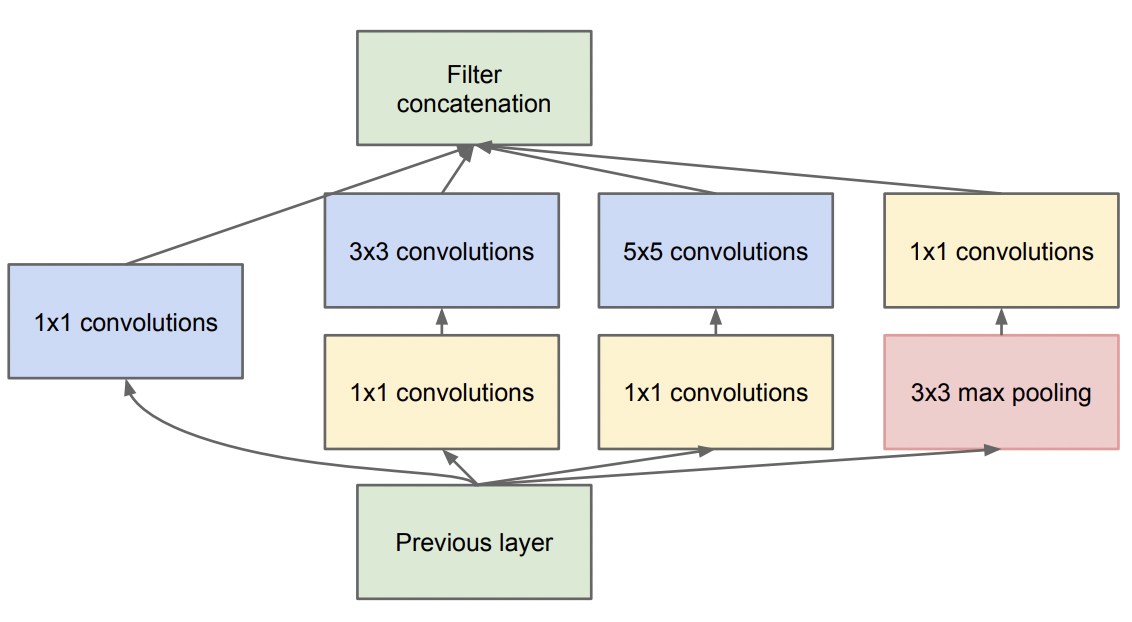

In summary:
- The input size image is 224 × 224.
- There are nine Inception blocks in this network.
- There are four max-pooling layers outside the Inception blocks, in which two layers are located between blocks 3–4 and block 7–8. These max-pooling layers help to reduce the size of the input data, thus reduce the model complexity as well as the computational cost.
- This network inherits the idea of using an average pooling layer from NiN, which helps to improve the model performance and reduce overfitting.
- A dropout layer (with 40%) is utilized before the linear layer. This is also an efficient regularization method to reduce the overfitting phenomena. The output layer uses the softmax activation function to give 1000 outputs which are corresponding to the number of categories in the ImageNet dataset.

Besides, some extra networks are added on the side, which encourages discrimination in the lower stages in the classifier, increases the gradient signal that gets backpropagation, and provides additional regularization. The structure of these networks includes:
- An average pooling layer with pooling size 5 × 5 and stride 3.
- A 1 × 1 convolutional layer with 128 filters for dimensional reduction and a rectified linear activation.
- A fully connected layer with 1024 units and a rectified linear activation.
- A dropout with a ratio of 70% of outputs.
- An output layer that used a softmax activation function to classify the object into one of 1000 classes.


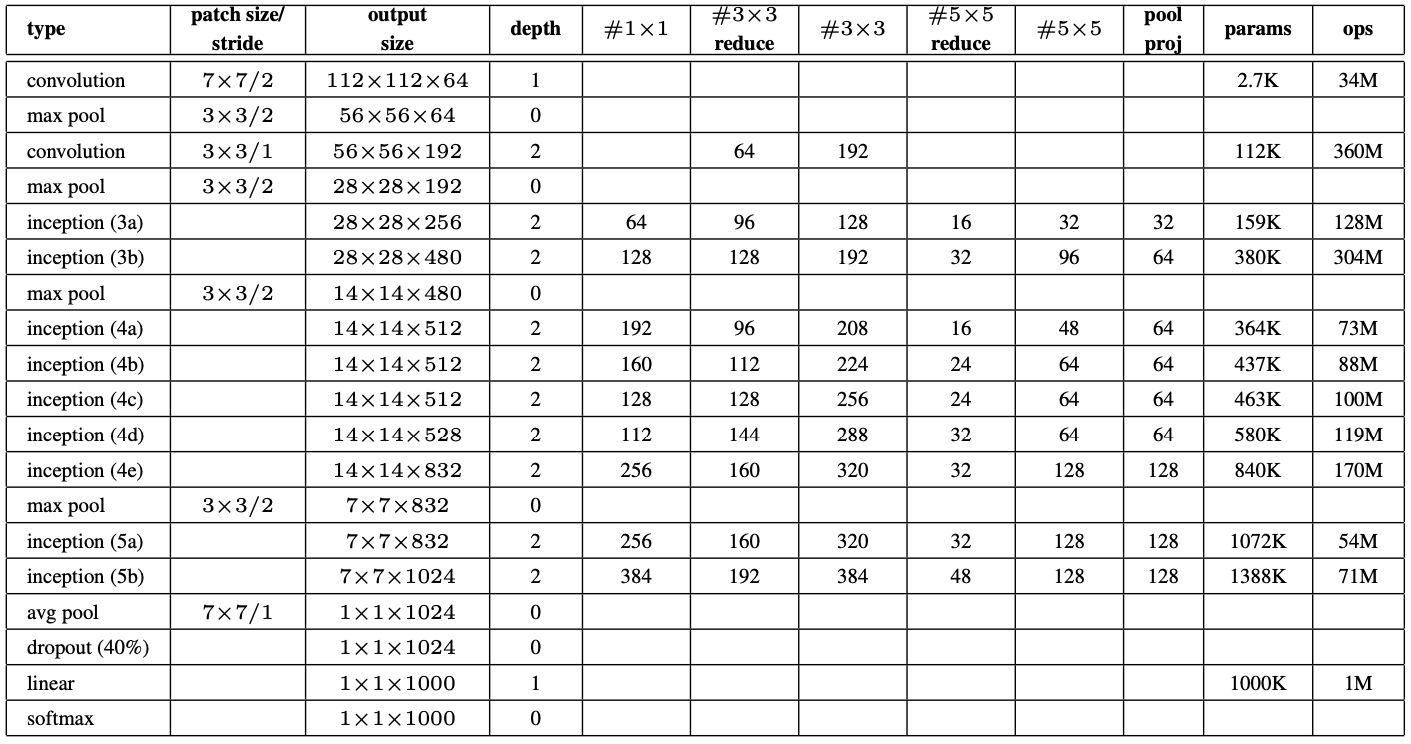

# II. Implementation of GoogLeNet on Keras

Firstly, we need to import some necessary libraries:

In [29]:
from keras.models import Model
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
import matplotlib.pylab as plt
from google.colab.patches import cv2_imshow
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from keras.callbacks import LearningRateScheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


create an Inception block 

In [30]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


Function to implement the GoogLeNet model:

In [31]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1, activation = 'sigmoid')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [39]:
model = GoogLeNet()

In [33]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 109, 109, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_118[0][0]']             
 )                                                                                        

Although the model is complicated to implement, the parameter number of the whole model is not large. The Dense layers always take a majority of parameters. Besides, the appearance of the global average pooling layers helps to reduce significantly the parameter number, thus reducing the computational complexity of the model.

# IV. Conclusion
We have discovered the architecture as well as the implementation of the GoogLeNet model on the Keras platform. It is composed of Inception blocks. Each block has a special architecture where it extracts simultaneously the input features through four parallel paths. Besides, the 1×1 convolutional layers are maximum applied in these paths to reduce channel dimensionality. Moreover, the application of the max-pooling layer between some Inception blocks plays a role in reducing the resolution, thus reducing the computational complexity. In summary, the parameter number of this model is 6x smaller than the Alexnet model and much smaller than the VGG model. Especially, it outperforms these models. This interesting architecture of GoogLeNet is also an inspiration for the appearance of later models.

**References:**

[1] Szegedy, Christian, et al. “Going deeper with convolutions.” Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

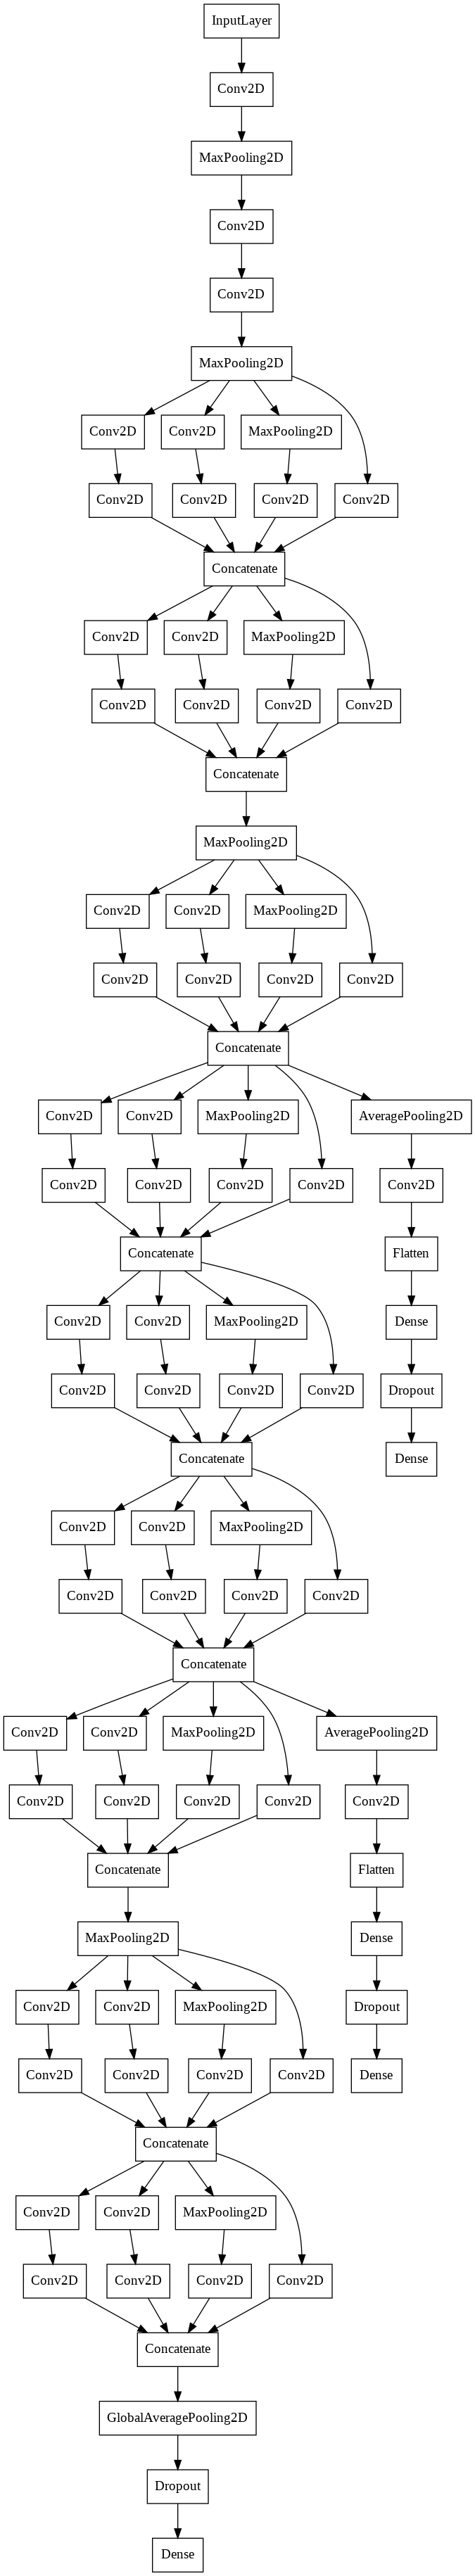

In [27]:
keras.utils.plot_model(model, show_layer_names=False)

##Data Processing
Get directory path of train image data and y_train excel file of classes for each multilabel. Add each slice from train image data folder to the csv file. This part is NOT coded dynamically. The "i" is where the file will start writing to. The "[filename, 1,1,1]" is hard coded for the labels of TRN_00 (1,1,1). It is then added to a new y_train csv file.

In [ ]:
path="/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/TRN_00/"
copy_df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/TB_y_train_copy.csv")
dir_list = os.listdir(path)
df = pd.DataFrame(columns=('ID', 'thick_walls', 'has_calcification', 'foci_around'))

i = 61
for filename in dir_list:
    df.loc[i] = df.loc[i] = [filename, 1,1,1]
    i += 1

pd.concat([copy_df, df]).to_csv('/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/new_y_train.csv', index=False)



The following code is used to take in an existing image directory and resize each image in the directory to match the dimensions of the input layer (224x224). That is then saved to a different directory.

In [ ]:
new_path = "/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/Updated_TRN_00/"
dir_list = os.listdir(path)
for filename in dir_list:
  image = cv2.imread(path + filename)
  up_points = (224,224)
  resized_down = cv2.resize(image, up_points, interpolation=cv2.INTER_LINEAR)
  cv2.imwrite(os.path.join(new_path, filename), resized_down)

The following code is modified from https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24. The next three code blocks are trained and plotted for each classification separately: thick walls, has calcification, and foci around. 

In [40]:
df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/new_y_train.csv")
columns=["thick_walls"]
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=datagen.flow_from_dataframe(
dataframe=df[:],
directory="/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/Updated_TRN_00/",
x_col="ID",
y_col=columns,
batch_size=10,
seed=42,
target_size=(224,224),
class_mode="raw",
shuffle=True)

Found 67 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 60 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


##Compile and fit the model


In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


6/6 [==============================] - 5s 61ms/step - loss: 1.0464 - dense_19_loss: 0.2028 - dense_16_loss: 0.2755 - dense_18_loss: 0.5681 - dense_19_accuracy: 0.9474 - dense_16_accuracy: 0.2456 - dense_18_accuracy: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 0s 50ms/step - loss: 0.0977 - dense_19_loss: 0.0000e+00 - dense_16_loss: 4.4384e-08 - dense_18_loss: 0.0977 - dense_19_accuracy: 1.0000 - dense_16_accuracy: 0.1228 - dense_18_accuracy: 0.0000e+00
Epoch 3/10
6/6 [==============================] - 0s 51ms/step - loss: 0.0060 - dense_19_loss: 0.0000e+00 - dense_16_loss: 4.3494e-17 - dense_18_loss: 0.0060 - dense_19_accuracy: 1.0000 - dense_16_accuracy: 0.1228 - dense_18_accuracy: 0.0000e+00
Epoch 4/10
6/6 [==============================] - 0s 51ms/step - loss: 0.0014 - dense_19_loss: 0.0000e+00 - dense_16_loss: 4.9351e-24 - dense_18_loss: 0.0014 - dense_19_accuracy: 1.0000 - dense_16_accuracy: 0.0702 - dense_18_accuracy: 0.0000e+00
Epoch 5/10
6/6 [===================

##Show the accuracy and loss of the model


dict_keys(['loss', 'dense_19_loss', 'dense_16_loss', 'dense_18_loss', 'dense_19_accuracy', 'dense_16_accuracy', 'dense_18_accuracy'])


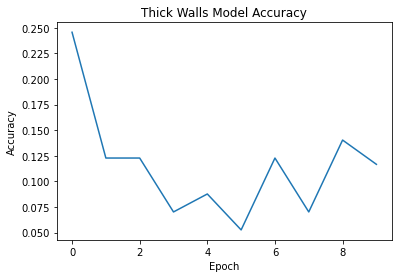

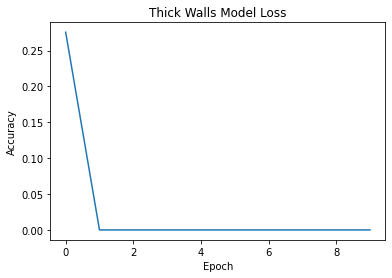

In [42]:
history_dict = history.history

plt.figure()
plt.plot(history.history['dense_16_accuracy'])
plt.title('Thick Walls Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(history.history['dense_16_loss'])
plt.title('Thick Walls Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [44]:
model = GoogLeNet()

df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/new_y_train.csv")
columns=["has_calcification"]
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=datagen.flow_from_dataframe(
dataframe=df[:],
directory="/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/Updated_TRN_00/",
x_col="ID",
y_col=columns,
batch_size=10,
seed=42,
target_size=(224,224),
class_mode="raw",
shuffle=True)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=10
)


Found 67 validated image filenames.
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 60 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


6/6 [==============================] - 4s 59ms/step - loss: 1.0046 - dense_29_loss: 0.2136 - dense_26_loss: 0.2252 - dense_28_loss: 0.5658 - dense_29_accuracy: 0.8947 - dense_26_accuracy: 0.1404 - dense_28_accuracy: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.1037 - dense_29_loss: 0.0000e+00 - dense_26_loss: 1.0503e-12 - dense_28_loss: 0.1037 - dense_29_accuracy: 1.0000 - dense_26_accuracy: 0.0702 - dense_28_accuracy: 0.0000e+00
Epoch 3/10
6/6 [==============================] - 0s 50ms/step - loss: 0.0052 - dense_29_loss: 0.0000e+00 - dense_26_loss: 5.6918e-27 - dense_28_loss: 0.0052 - dense_29_accuracy: 1.0000 - dense_26_accuracy: 0.0702 - dense_28_accuracy: 0.0000e+00
Epoch 4/10
6/6 [==============================] - 0s 51ms/step - loss: 5.7288e-04 - dense_29_loss: 0.0000e+00 - dense_26_loss: 1.4634e-38 - dense_28_loss: 5.7288e-04 - dense_29_accuracy: 1.0000 - dense_26_accuracy: 0.0877 - dense_28_accuracy: 0.0000e+00
Epoch 5/10
6/6 [===========

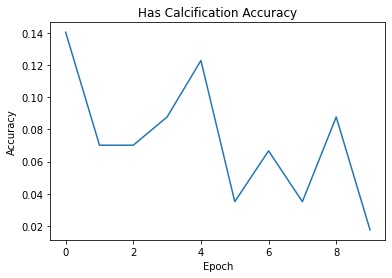

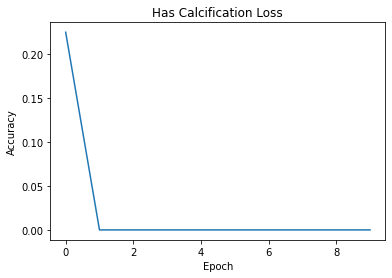

In [46]:
history_dict = history.history

plt.figure()
plt.plot(history.history['dense_26_accuracy'])
plt.title('Has Calcification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(history.history['dense_26_loss'])
plt.title('Has Calcification Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [47]:
model = GoogLeNet()

df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/new_y_train.csv")
columns=["foci_around"]
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=datagen.flow_from_dataframe(
dataframe=df[:],
directory="/content/drive/My Drive/Colab Notebooks/TB_Caverns_Data/Updated_TRN_00/",
x_col="ID",
y_col=columns,
batch_size=10,
seed=42,
target_size=(224,224),
class_mode="raw",
shuffle=True)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=10
)

Found 67 validated image filenames.
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 60 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


6/6 [==============================] - 5s 64ms/step - loss: 1.0510 - dense_34_loss: 0.2222 - dense_31_loss: 0.2784 - dense_33_loss: 0.5504 - dense_34_accuracy: 0.9474 - dense_31_accuracy: 0.1930 - dense_33_accuracy: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 0s 53ms/step - loss: 0.0892 - dense_34_loss: 0.0000e+00 - dense_31_loss: 9.6619e-08 - dense_33_loss: 0.0892 - dense_34_accuracy: 1.0000 - dense_31_accuracy: 0.2281 - dense_33_accuracy: 0.0000e+00
Epoch 3/10
6/6 [==============================] - 0s 57ms/step - loss: 0.0046 - dense_34_loss: 0.0000e+00 - dense_31_loss: 6.6537e-28 - dense_33_loss: 0.0046 - dense_34_accuracy: 1.0000 - dense_31_accuracy: 0.1404 - dense_33_accuracy: 0.0000e+00
Epoch 4/10
6/6 [==============================] - 0s 49ms/step - loss: 4.9568e-04 - dense_34_loss: 0.0000e+00 - dense_31_loss: 0.0000e+00 - dense_33_loss: 4.9568e-04 - dense_34_accuracy: 1.0000 - dense_31_accuracy: 0.1404 - dense_33_accuracy: 0.0000e+00
Epoch 5/10
6/6 [===========

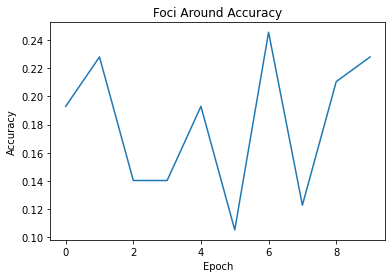

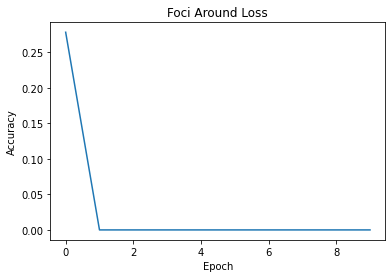

In [49]:
history_dict = history.history

plt.figure()
plt.plot(history.history['dense_31_accuracy'])
plt.title('Foci Around Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(history.history['dense_31_loss'])
plt.title('Foci Around Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()